# This is the instructions for HW 2.

In this homework, you have three programming Questions

The submission deadline is **Sep 25th 23:59PM**. Please submit the ipynb file to the canvas

===============================================

In [2]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# Useful metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/Users/rochishnu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# MNIST Dataset

First we import the dataset using torchvision. 

We can directly divide them into training and testing datasets by changing the *train* parameter. 

The *MNIST* class returns a list of tuples of the form *(PIL image, label)*. There are 60,000 train and 10,000 test images. 

The test dataset is also labelled.

In [3]:
from torchvision.datasets import MNIST

# Importing training and testing data from torchvision dataset collection
train_data = MNIST(root='./data', download=True, train=True, transform=None)
test_data = MNIST(root='./data', download=True, train=False, transform=None)

print(f"Number of Train images:\t {len(train_data)}")
print(f"Number of Test images:\t {len(test_data)}")

Number of Train images:	 60000
Number of Test images:	 10000


## MNIST Example

Let us take a look a how the image looks like. Each image is $(28\times 28)$ 2D array of integers ranging from 0 to 255. 

Notice that the image is not in grayscale because matplotlib assumes the input to be a colored

Shape: (28, 28)


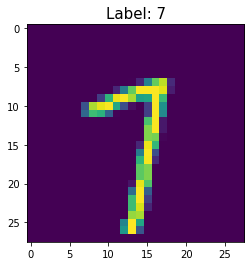

In [4]:
# Separate out image and its label
img, label = train_data[42]

print(f"Shape: {np.asarray(img).shape}")

# Plotting the image
plt.figure()
plt.imshow(img)
plt.title(f"Label: {label}", fontsize=15)
plt.show()

## Plotting all digits

Let us plot all digits in grayscale to have a better understanding of how each digit is represented.

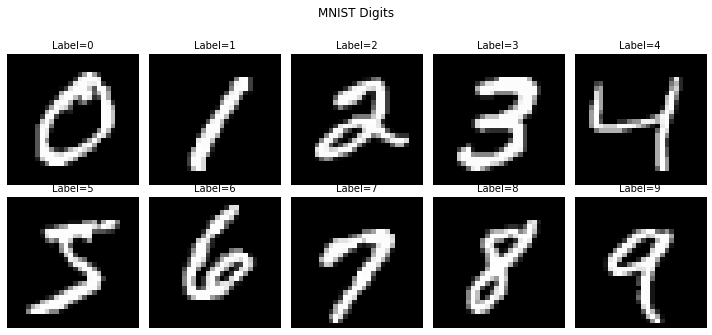

In [5]:
# Storing the indices of respective digits in training dataset
unique_ids = [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]

# Plotting all digits in a 2x5 grid
plt.figure(figsize=(10,5))
for i,idx in enumerate(unique_ids):
    i = i + 1
    ax1 = plt.subplot(2, 5, i)
    plt.axis('off')
    ax1.imshow(train_data[idx][0], plt.cm.gray)
    ax1.set_aspect('equal')
    ax1.set_title(f'Label={i-1}', fontsize=10)
plt.subplots_adjust(wspace=0.1, hspace=0, top=1)
plt.suptitle('MNIST Digits')
plt.tight_layout()
plt.show()

## Data Preprocessing

To use the dataset, we must do the following:
1. Split the tuple into features-$X$ and labels-$Y$
2. Since the input is a 2D array, flatten each image to 1D array of length $784 = (28 \times 28)$
3. Convert *train_data* and *test_data* into iterable lists of float type

### Format of the Datasets:

*X_train* : $60,000\times784$ numpy array of flattened versions of training images

*Y_train* : $1\times60,000$ numpy array of the true labels of the corresponding training images

*X_test* : $10,000\times784$ numpy array of flattened versions of test images

*Y_test* : $1\times10,000$ numpy array of the true labels of the corresponding test images

In [6]:
# Splitting train and test datasets
# Convert pixel values to float
X_train = [np.asarray(img).flatten().astype(np.float32) for img,label in train_data]
Y_train = [label for img,label in train_data]

X_test = [np.asarray(img).flatten().astype(np.float32) for img,label in test_data]
Y_test = [label for img,label in test_data]

### Plotting Multi-dimensional Clusters
Our input is 784-dimensional. To plot on a 2D graph,
1. Principal Component Analysis (PCA): Use PCA to extract 50 most important features
2. t-distributed Stochastic Neighbor Embedding (t-SNE): Reduce the 50 features to 2 axes

For reference: [Visualising high-dimensional datasets using PCA and t-SNE in Python
](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [7]:
def plot_clusters(X, Y):
    # Apply PCA
    pca = PCA(50)
    pca_result = pca.fit_transform(X)

    # Apply TSNE
    tsne = TSNE(n_components=2, verbose=0, perplexity=30)
    tsne_result = tsne.fit_transform(pca_result)

    dims = np.transpose(tsne_result)    # Pivot train_data
    n_labels = len(set(Y))              # Get number of unique labels

    # Plotting clusters
    plt.figure()
    sns.scatterplot(dims[0], dims[1], hue=Y, palette=sns.color_palette("hls",n_labels), legend='full')
    plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
    plt.show()

In [8]:
plot_clusters(X_test, Y_test)

: 

: 

# Question 1: Image Classification using KNN

## KNN Algorithm

### Inputs
- *x_train*: Flattened train images
- *y_train*: Labels of the train images
- *k*: K-value for k nearest neighbours

### Algorithm
It takes a vector $p$ and returns the predicted class.

Steps:
1. Calculate L2 distance from all train datapoints
2. Sort the labels based on the distances
3. Extract the most frequent label from first $k$ labels in the sorted array

### Runtime Complexity
$O(N*f*k)$ where $N$ is number of training images, $f$ is number of features in each image, $k$ is nearest neighbours. 

In [ ]:
# Define a KNN class
class KNN():

    # Initializing training variables
    def __init__(self, k=10):
        self.x_train = X_train      # Feature dataset
        self.y_train = Y_train      # Label dataset
        self.k = k                  # k nearest neighbours

    # Prediction function that takes 1D (784,) array as input
    # Returns the predicted class based on k-nn
    def predict(self, p):
        dist_from_p = [self.distance(p, x) for x in self.x_train]               # Calculate distance from X
        sorted_labels = [i for _,i in sorted(zip(dist_from_p, self.y_train))]   # Sort labels
        k_nearest = sorted_labels[:self.k]                                      # Collect closest k neighbours
        return max(set(k_nearest), key=k_nearest.count)                         # Return highest occurring label

    # Helper to calculate distance
    # Use order = 2 for euclidean, 1 for manhattan, -inf for chebyshev
    def distance(self, v1, v2):
        return np.linalg.norm(v1-v2, ord=2)

## Testing Phase

Note that because of high time complexity, we cannot test the whole dataset. Thus we will consider only a small subset of the test data.

In [ ]:
# Selecting n random indices
random.seed(42)
idx_20 = random.sample(list(np.arange(len(X_test))), 20)       # 20 indices
idx_200 = random.sample(list(np.arange(len(X_test))), 200)     # 200 indices

xtest_20, ytest_20 = [X_test[i] for i in idx_20], [Y_test[i] for i in idx_20]
xtest_200, ytest_200 = [X_test[i] for i in idx_200], [Y_test[i] for i in idx_200] 

### Test 1: $k$ Parameter Tuning
Test accuracy and running time with different values of $k$
- Test Size: $20$
- Test the accuracy for $k \in \{1, 2, 5, 10, 20\}$
- Check running time

In [ ]:
# Function to get time statistics
def time_stats(start, end):
    elapsed = end - start
    mins = int(elapsed / 60)            # Get minutes
    secs = (elapsed - (mins * 60))      # Get seconds
    return mins, secs

In [ ]:
k_values = [1,2,5,10,20]
models = [KNN(k) for k in k_values]     # List to store knn models for variable k

for i,model in enumerate(models):
    print(f"k = {k_values[i]}", sep='\t')
    y_preds = []
    start = time.monotonic()    # Start stopwatch
    for x in xtest_20:
        y_preds.append(model.predict(x))
    stop = time.monotonic()      # Stop stopwatch
    mins, secs = time_stats(start, stop)
    print(f'Time: {mins}m {secs:.2f}s', sep='\t')
    print(f"Accuracy: {accuracy_score(ytest_20, y_preds):.2f}\n")

k = 1
Time: 0m 11.51s
Accuracy: 0.90

k = 2
Time: 0m 11.65s
Accuracy: 1.00

k = 5
Time: 0m 12.75s
Accuracy: 0.90

k = 10
Time: 0m 11.50s
Accuracy: 0.90

k = 20
Time: 0m 11.55s
Accuracy: 0.90



### Test 2: Error Analysis
Let us take a look at the incorrect labels
- Test Size: $20$, $k=10$
- Plot wrong labels

In [ ]:
model = KNN()   # Initialize model
y_true = []     # List to store true labels
y_miss = []     # List to store incorrect labels
x_miss = []     # List to store corresponding images
for i,x in enumerate(xtest_20):
    y_p = model.predict(x)

    # Compare prediction with true label
    if y_p!=ytest_20[i]:
        y_true.append(ytest_20[i])
        y_miss.append(y_p)
        x_miss.append(x)

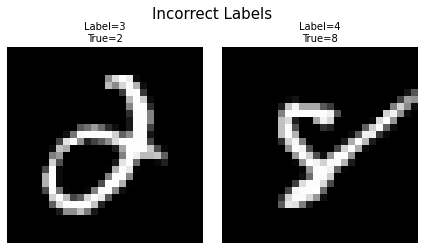

In [ ]:
# Plotting the false images
plt.figure()
for i, img in enumerate(x_miss):
    i = i + 1
    ax1 = plt.subplot(1, len(x_miss), i)
    plt.axis('off')
    ax1.imshow(img.reshape((28,28)), plt.cm.gray)
    ax1.set_title(f"Label={y_miss[i-1]}\nTrue={y_true[i-1]}", fontsize=10)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.suptitle('Incorrect Labels', fontsize=15)
plt.show()

### Test 3: Quality Analysis
Check quality tests for larger test dataset.
- Test size = $200$, $k=10$ 
- Show accuracy, precision and recall score
- Plot confusion matrix


### Metrics

||1 (true)| 0 (true)|
|:-:|:------------------:|:-------------------:|
|1 (pred)|True Positive (TP)|False Positive (FP)|
|0 (pred)|False Negative (TN)|True Negative (FN)|

$Acc= \cfrac{TP+TN}{TP+FP+TN+FN} \qquad Prec = \cfrac{TP}{TP+FP} \qquad Rec = \cfrac{TP}{TP+FN}$

In [ ]:
# Initialize model and predict
model = KNN()                                               
y_preds = [model.predict(x) for x in xtest_200]

acc = accuracy_score(ytest_200, y_preds)                        # Accuracy
prec = precision_score(ytest_200, y_preds, average='macro')     # Precision
rec = recall_score(ytest_200, y_preds, average='macro')         # Recall

print(f"Accuracy = {acc:.3f}\t Precision = {prec:.3f}\t Recall = {rec:.3f}")

Accuracy = 0.980	 Precision = 0.979	 Recall = 0.984


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm, annot=True, annot_kws={'size':13}, xticklabels=np.arange(10), yticklabels=np.arange(10), cmap='Blues')
    plt.xlabel('Predicted Class', fontsize=16)
    plt.ylabel('True Class', fontsize=16)
    plt.show(block=False)

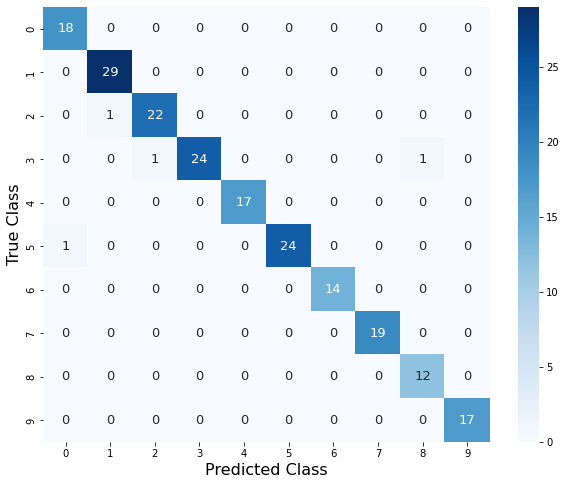

In [ ]:
plot_confusion_matrix(ytest_200, y_preds)

# Question 2: Image Classification using KMeans

## KMeans Algorithm

### Inputs
- *x_train*: Flattened train images
- *y_train*: Labels of the train images
- *k*: K-value for k clusters

### Parameters
- *max_iter*: Maximum number of iterations
- *centroids*: Geometric centroid of clusters, $C = \{c_0, c_1 ⋯ c_k\}$
- *prev_preds, new_preds*: Labels of the clusters, $Y$

### Algorithm
It takes the dataset as input and returns an unsupervised labelling of the data.

Steps:
1. Initialize $k$ centroids randomly $(C_0)$
2. Cluster images by labelling them to the closest centroid based on L2 distance $(C_{i-1} → Y_i)$
3. Calculate new centroid based on clusters obtained $(Y_i → C_i)$
4. Repeat steps $2$ and $3$ until maximum iterations is reached or there is no change in the clusters

### Runtime Complexity
$O(N^2)$ where $N$ is number of training images. Note that the kmeans algorithm is independent of the number of clusters.

In [ ]:
# Defining a KMeans class
class KMeans():

    # Initializing training and prediction variables
    def __init__(self, kind, max_iter=100):
        self.x_train = X_test       # Feature dataset
        self.y_train = Y_test       # Label dataset
        self.k = 10                 # K clusters

        self.max_iter = max_iter    # Max iterations
        self.curr_iter = 0          # Iteration counter

        self.centroids = self.init_centroids(kind)      # Initialize base centroids

        self.prev_preds = list(np.zeros(len(Y_test)))   # Stores predictions from (n-1)th iteration
        self.new_preds = list(np.zeros(len(Y_test)))    # Stores new predictions after update
    
    # Function to initialize centroids at the start
    def init_centroids(self, kind):

        # Randomly choose k starting points
        if kind=='random':
            random.seed(42)
            return random.sample(self.x_train, 10)
        
        # Randomly choose k starting points in distinct classes
        elif kind=='unique':
            cents = []
            random.seed(42)
            for i in range(self.k):
                cents.append(random.choice([x for x,y in zip(self.x_train, self.y_train) if y==i]))
            return cents
        
        # Randomly choose k starting points from same random class
        elif kind=='monoclass':
            random.seed(42)
            label = random.choice(np.arange(self.k))
            return random.sample([x for x,y in zip(self.x_train, self.y_train) if y==label], self.k)
        
        # Randomly choose k uniformly placed starting points
        elif kind=='uniform':
            random.seed(42)
            x_min, x_max = np.min(self.x_train), np.max(self.x_train)
            return [random.uniform(x_min, x_max) for _ in range(self.k)] 

    # Helper to calculate distance
    # Use order = 2 for euclidean, 1 for manhattan, -inf for chebyshev
    def distance(self, v1, v2):
        return np.linalg.norm(v1-v2, ord=2)
    
    # Helper to evaluate stopping condition
    def stopping_criteria(self):

        # If current iteration has reached maximum
        if self.curr_iter>=self.max_iter:
            return True
        
        # If predicted labels have not changed after an iteration
        elif self.prev_preds==self.new_preds and self.curr_iter!=0:
            return True

        else: return False

    # Function to update the predicted class from new centroids
    def update_cluster(self):
        for i,x in enumerate(self.x_train):
            distance_from_cent = [self.distance(x, c) for c in self.centroids]      # Get distances from each centroid
            y_min = distance_from_cent.index(min(distance_from_cent))               # Get class of minimum distance
            self.new_preds[i] = y_min                                               # Update new prediction

    # Function to update cluster centroids from new predictions
    def update_centroids(self):
        for i in range(self.k):
            single_cluster = [x for x,y in zip(self.x_train, self.new_preds) if y==i]   # Collect points from same class
            if len(single_cluster)==0:                                                  # Escape case if no points are selected
                continue
            self.centroids[i] = sum(single_cluster)/len(single_cluster)                 # Update new centroids

    # Main clustering algorithm
    def clustering_algo(self):

        # Evaluating stopping criteria
        while not self.stopping_criteria():
            self.prev_preds = list(np.copy(self.new_preds))     # Reassign previous predictions
            self.update_cluster()                               # Update predictions to get new predictions
            self.update_centroids()                             # Update centroids to get new centroids
            self.curr_iter += 1                                 # Increment iteration counter

## Testing Phase

### Test 1: Centroid parameter tuning
Test the algorithm with various sets of starting centroids
- Extent of clustering
- Convergence time
- Clustering plots

In [ ]:
models = []
init_kinds = ['random', 'unique', 'monoclass', 'uniform']

for i,kind in enumerate(init_kinds):
    model = KMeans(kind=kind)
    models[i] = model

10
no change
10
no change
10
no change
10
no change


Let us look at the point of convergence in iterations. If iterations $≥100$, then the clustering algorithm may not have converged. Also the clustered plots after dimensional reduction is shown.

In [ ]:
m4.curr_iter
if 0 in m4.new_preds:
    print('herer')

In [ ]:
# Total number of iterations for each case
for i,model in enumerate(models):
    print(f"{init_kinds[i]}: {model.curr_iter}")

59
48
66
32


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


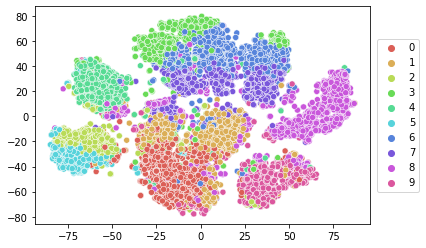

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


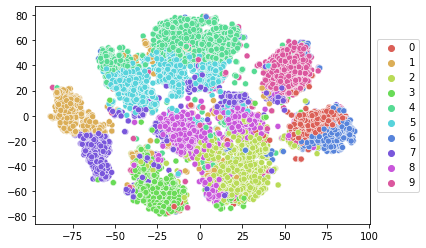

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


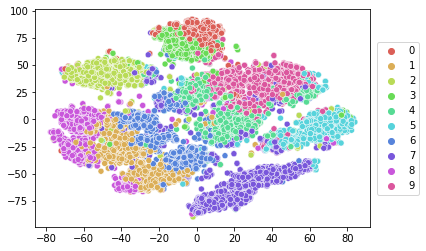

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_clusters(m1.x_train, m1.new_preds)
plot_clusters(m2.x_train, m2.new_preds)
plot_clusters(m3.x_train, m3.new_preds)
plot_clusters(m4.x_train, m4.new_preds)

# Question 3: Linear regression

## Linear Regression Algorithm

## Inputs
- *x_GT*: Ground truth values of $x$
- *y_GT*: Ground truth values of $y$

### Parameters
- *th*: Sequence of $\theta$ values
- *lr*: Learning rate - $\alpha$
- *max_iter*: Maximum number of iterations

### Algorithm
Equation: $\quad y = \theta_0x^2 + \theta_1x + \theta_2$

Using this equation, we will perform linear regression with learning rate $\alpha = 0.0005$ and maximum of 6000 iterations. The loss function and its partial derivative is given by:

1. Calculate loss: $L = \sum(y - \hat{y})^2$ where $y = \theta_0x^2 + \theta_1x + \theta_2$

2. Calculate partial derivatives: $\cfrac{\partial L}{\partial \theta_0} = \sum 2x^2(y - \hat{y}) \qquad  \cfrac{\partial L}{\partial \theta_1} = \sum 2x(y - \hat{y}) \qquad \cfrac{\partial L}{\partial \theta_2} = \sum 2(y - \hat{y})$   

3. Update the coefficients: $\theta_i = \theta_i - \alpha \cfrac{\partial L}{\partial \theta_i}$ where $i \in \{0,1,2\}$

### Runtime Complexity
$O(k)$ where $k$ is dimension of input vectors.

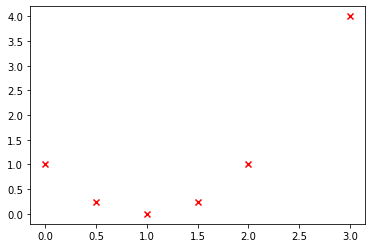

In [3]:
# Ground truth values
x_GT = np.array([0, 0.5, 1, 1.5, 2, 3])
y_GT = np.array([1, 0.25, 0, 0.25, 1, 4])

# Plotting the ground truth values
plt.scatter(x_GT, y_GT,marker='x', color='r')
plt.show()

In [4]:
class LinearRegression():
    def __init__(self):

        # Ground truth values
        self.x_GT = np.array([0, 0.5, 1, 1.5, 2, 3])
        self.y_GT = np.array([1, 0.25, 0, 0.25, 1, 4])

        self.th = np.zeros(3)       # Theta coefficients
        self.lr = 5e-4              # Learning rate
        self.max_iter = 6000        # Max iterations
        self.losses = []            # Store loss after each iteration
    
    # Function to update theta coefficients
    def update_theta(self):

        # Update theta_0
        d_th0 = 0.0
        for x,y in zip(self.x_GT, self.y_GT):
            d_th0 += 2 * (x**2) * (self.th[0]*(x**2) + self.th[1]*x + self.th[2] - y)   # Get loss derivative
        self.th[0] = self.th[0] - d_th0*self.lr         
        
        # Update theta_1
        d_th1 = 0.0
        for x,y in zip(self.x_GT, self.y_GT):   
            d_th1 += 2 * x * (self.th[0]*(x**2) + self.th[1]*x + self.th[2] - y)        # Get loss derivative
        self.th[1] = self.th[1] - d_th1*self.lr

        # Update theta_2
        d_th2 = 0.0
        for x,y in zip(self.x_GT, self.y_GT):
            d_th2 += 2 * (self.th[0]*(x**2) + self.th[1]*x + self.th[2] - y)            # Get loss derivative
        self.th[2] = self.th[2] - d_th0*self.lr
    
    # Gradient Descent algorithm
    def grad_descent(self):
        for i in range(self.max_iter):
            loss = self.calculate_loss()    # Calculate loss
            self.losses.append(loss)        # Store loss
            self.update_theta()             # Update coefficients
            
            # Every 1000th iteration plot the fitted polynomial
            if (i+1)%1000==0:
                print(f"Iter: {i+1}")
                print(f"Loss: {loss:.5f}")
                self.plot_graph()

    # Function to calculate loss
    def calculate_loss(self):
        loss = 0.0
        for x,y in zip(self.x_GT, self.y_GT):
            y_pred = self.th[0]*(x**2) + self.th[1]*x + self.th[2]      # Get predicted value
            loss += (y_pred - y)**2                                     # Get squared error
        return loss
    
    # Helper to plot graph of fitted polynomial
    def plot_graph(self):
        xpoints = np.linspace(0, 3, 101)
        ypoints = [self.th[0]*(x**2) + self.th[1]*x + self.th[2] for x in xpoints]
        plt.figure()
        plt.scatter(self.x_GT, self.y_GT, marker='x', color='red', label='Ground truth')
        plt.plot(xpoints, ypoints, 'b', label='Predict-fit')
        plt.legend()
        plt.show()
    
    # Helper to plot loss after completion
    def plot_loss(self):
        plt.figure()
        plt.plot(self.losses, 'b', label='loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Loss Graph')
        plt.show()

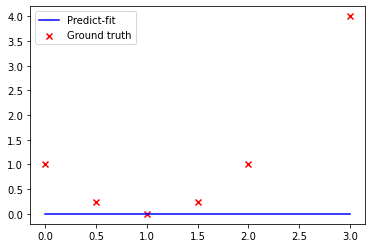

Iter: 1000
Loss: 0.64728


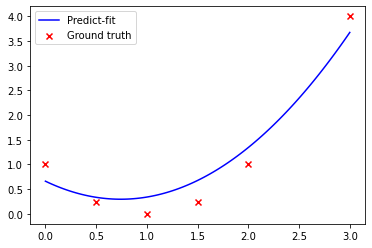

Iter: 2000
Loss: 0.15055


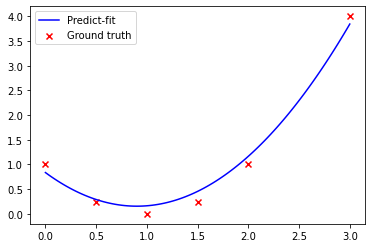

Iter: 3000
Loss: 0.03502


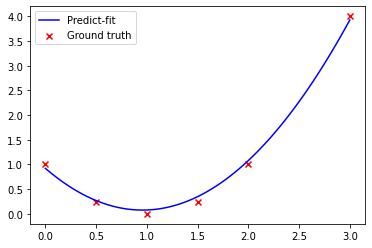

Iter: 4000
Loss: 0.00814


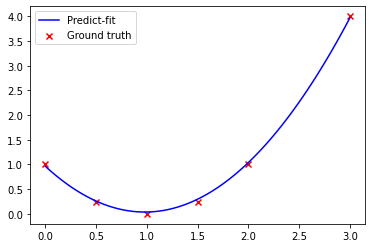

Iter: 5000
Loss: 0.00189


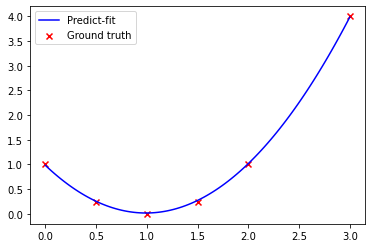

Iter: 6000
Loss: 0.00044


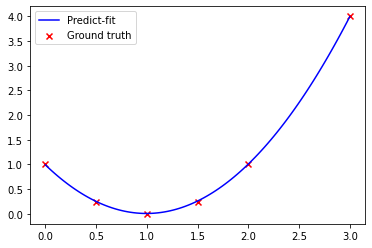

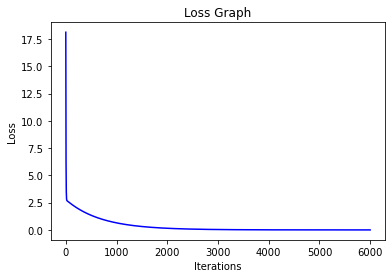

In [5]:
model = LinearRegression()
model.plot_graph()
model.grad_descent()
model.plot_loss()

Rochishnu Banerjee

banerjr2@miamioh.edu